# Water Observations Nov-Mar
## 1.6.0 vs 2.0.0

Check list:

    [x] compare the two versions in Maps/Terria
    [x] compare the two versions in Explorer
    [ ] plot random tiles, check impact of cloud and shadow buffering on no data values. Years 1990, 2010, 2015, 2022.




In [1]:
import datacube
import pandas as pd
import sys
import rioxarray as rioxr
import rasterio
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

dc = datacube.Datacube(app="")

In [2]:
# functions to use

def load_wo_16(tile, time):
    """
    load wo v1.6.0 over tile extent.
    """
    wo_16 = dc.load(
                product="ga_ls_wo_fq_nov_mar_3",
                region_code = tile, 
                time=time,
    )
    return wo_16

def load_wo_2(tile, year):
    """
    load wo v2.0.0 from s3. loads three layers, clear, wet and frequency. 
    """
    base_url_clear = "s3://dea-public-data/derivative/ga_ls_wo_fq_nov_mar_3/2-0-0/{}/{}/{}-11--P5M/ga_ls_wo_fq_nov_mar_3_{}_{}-11--P5M_final_count_clear.tif"
    base_url_wet = "s3://dea-public-data/derivative/ga_ls_wo_fq_nov_mar_3/2-0-0/{}/{}/{}-11--P5M/ga_ls_wo_fq_nov_mar_3_{}_{}-11--P5M_final_count_wet.tif"
    base_url_freq = "s3://dea-public-data/derivative/ga_ls_wo_fq_nov_mar_3/2-0-0/{}/{}/{}-11--P5M/ga_ls_wo_fq_nov_mar_3_{}_{}-11--P5M_final_frequency.tif"
    x_val = tile[:3]
    y_val = tile[-3:]
    url_clear = base_url_clear.format(x_val, y_val, year, tile, year)
    url_wet = base_url_wet.format(x_val, y_val, year, tile, year)
    url_freq = base_url_freq.format(x_val, y_val, year, tile, year)
    wo_2_clear = rioxr.open_rasterio(url_clear)
    wo_2_wet = rioxr.open_rasterio(url_wet)
    wo_2_freq = rioxr.open_rasterio(url_freq)
    return wo_2_clear, wo_2_wet, wo_2_freq

tile_lookup = pd.read_csv('grid_lookup.csv', sep=',', na_values=['NA'])
def lookup_old_value(new_value):
    """
    returns old region code
    """
    result = tile_lookup[tile_lookup['new'] == new_value]
    result = result['old'].values[0]
    return result    
    
def plot_tile(tile, year):
    """
    Plot version 1.6.0 and 2.0.0 WO products next to each other.
    """
    tile_old = lookup_old_value(tile)
    v16 = load_wo_16(tile_old, year)
    v2_clear, v2_wet, v2_freq = load_wo_2(tile, year)
    
    # Sum clear and wet counts across the layers
    # merged_clear_count_v16 = v16.count_clear.sum(axis=0)
    # merged_wet_count_v16 = v16.count_wet.sum(axis=0)

    # Recompute the frequency based on merged counts
    # merged_frequency_v16 = (merged_wet_count_v16 / merged_clear_count_v16)
    
    # use this for nan
    # nodata_16 = v16['frequency'].isnull().sum().item()
    # nodata_2 = v2_freq.isnull().sum().item() 
    # percent_change = ((nodata_2 - nodata_16) / nodata_16) * 100
    
    # use this for -999
    # nodata_16 = (merged_clear_count_v16 == -999).sum().item()
    nodata_16 = (v16.count_clear[0] == -999).sum().item()
    nodata_2 = (v2_clear == -999).sum().item()

    if nodata_16 == 0:
        percent_change = float('inf') if nodata_2 > 0 else 0  
    else:
        percent_change = ((nodata_2 - nodata_16) / nodata_16) * 100
    
    print('---------------------------------')
    print(f'-------------{tile}--------------')
    print('---------------------------------')
    print(f'V 1.6.0 NaN count (clear): {nodata_16:,}')
    print(f'V 2.0.0 NaN count (clear): {nodata_2:,}')
    print(f'NaN percent change: {percent_change:.2f}%')
    print('---------------------------------')
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    # img1 = axes[0, 0].imshow(merged_clear_count_v16, cmap='viridis', vmin=0)
    # axes[0, 0].set_title('v 1.6.0 clear count (merged)')
    # fig.colorbar(img1, ax=axes[0, 0])
    # img2 = axes[0, 1].imshow(merged_wet_count_v16, cmap='viridis', vmin=0)
    # axes[0, 1].set_title('v 1.6.0 wet count (merged)')
    # fig.colorbar(img2, ax=axes[0, 1])
    # img3 = axes[0, 2].imshow(merged_frequency_v16, cmap='Blues')
    # axes[0, 2].set_title('v 1.6.0 frequency (recomputed)')
    # fig.colorbar(img3, ax=axes[0, 2])
    img1 = axes[0, 0].imshow(v16.count_clear[0], cmap='viridis', vmin=0)
    axes[0, 0].set_title('v 1.6.0 clear count')
    fig.colorbar(img1, ax=axes[0, 0])
    img2 = axes[0, 1].imshow(v16.count_wet[0], cmap='viridis', vmin=0)
    axes[0, 1].set_title('v 1.6.0 wet count')
    fig.colorbar(img2, ax=axes[0, 1])
    img3 = axes[0, 2].imshow(v16.frequency[0], cmap='Blues')
    axes[0, 2].set_title('v 1.6.0 frequency')
    fig.colorbar(img3, ax=axes[0, 2])
    img4 = axes[1, 0].imshow(v2_clear.squeeze(), cmap='viridis', vmin=0)
    axes[1, 0].set_title('v 2.0.0 clear count')
    fig.colorbar(img4, ax=axes[1, 0])
    img5 = axes[1, 1].imshow(v2_wet.squeeze(), cmap='viridis', vmin=0)
    axes[1, 1].set_title('v 2.0.0 wet count')
    fig.colorbar(img5, ax=axes[1, 1])
    img6 = axes[1, 2].imshow(v2_freq.squeeze(), cmap='Blues')
    axes[1, 2].set_title('v 2.0.0 frequency')
    fig.colorbar(img6, ax=axes[1, 2])
    plt.tight_layout()
    plt.show()
      

---------------------------------
-------------x36y35--------------
---------------------------------
V 1.6.0 NaN count (clear): 0
V 2.0.0 NaN count (clear): 0
NaN percent change: 0.00%
---------------------------------


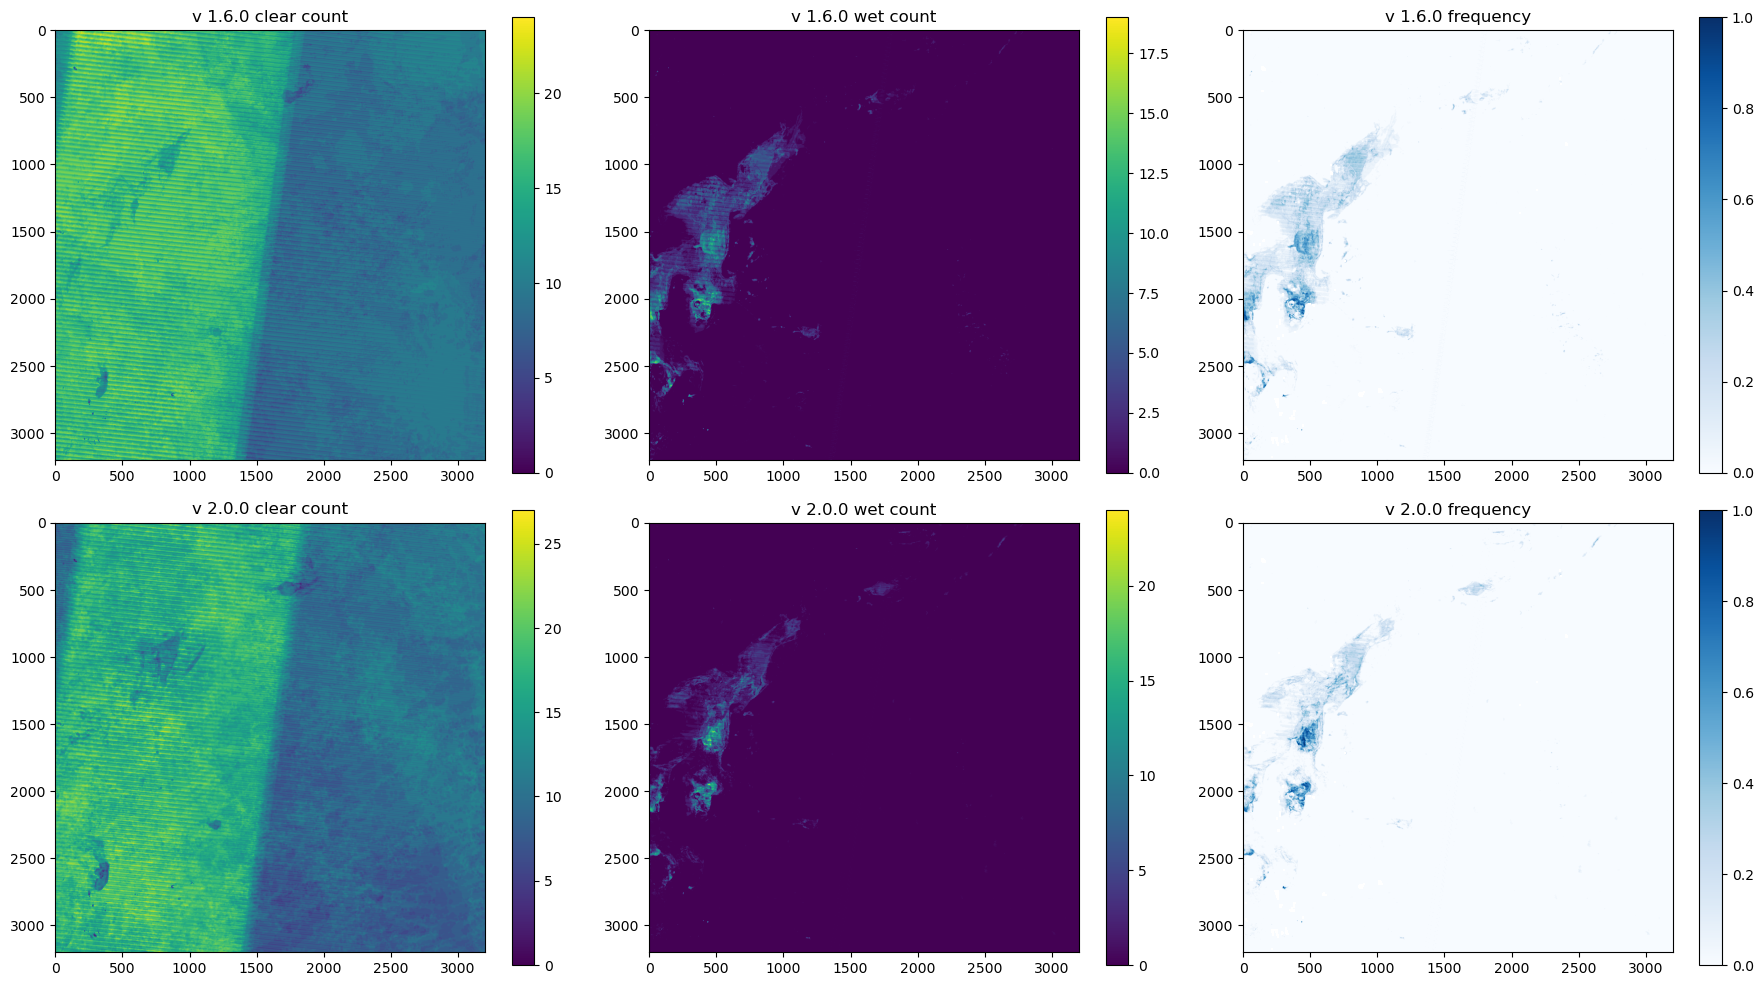

---------------------------------
-------------x31y48--------------
---------------------------------
V 1.6.0 NaN count (clear): 0
V 2.0.0 NaN count (clear): 0
NaN percent change: 0.00%
---------------------------------


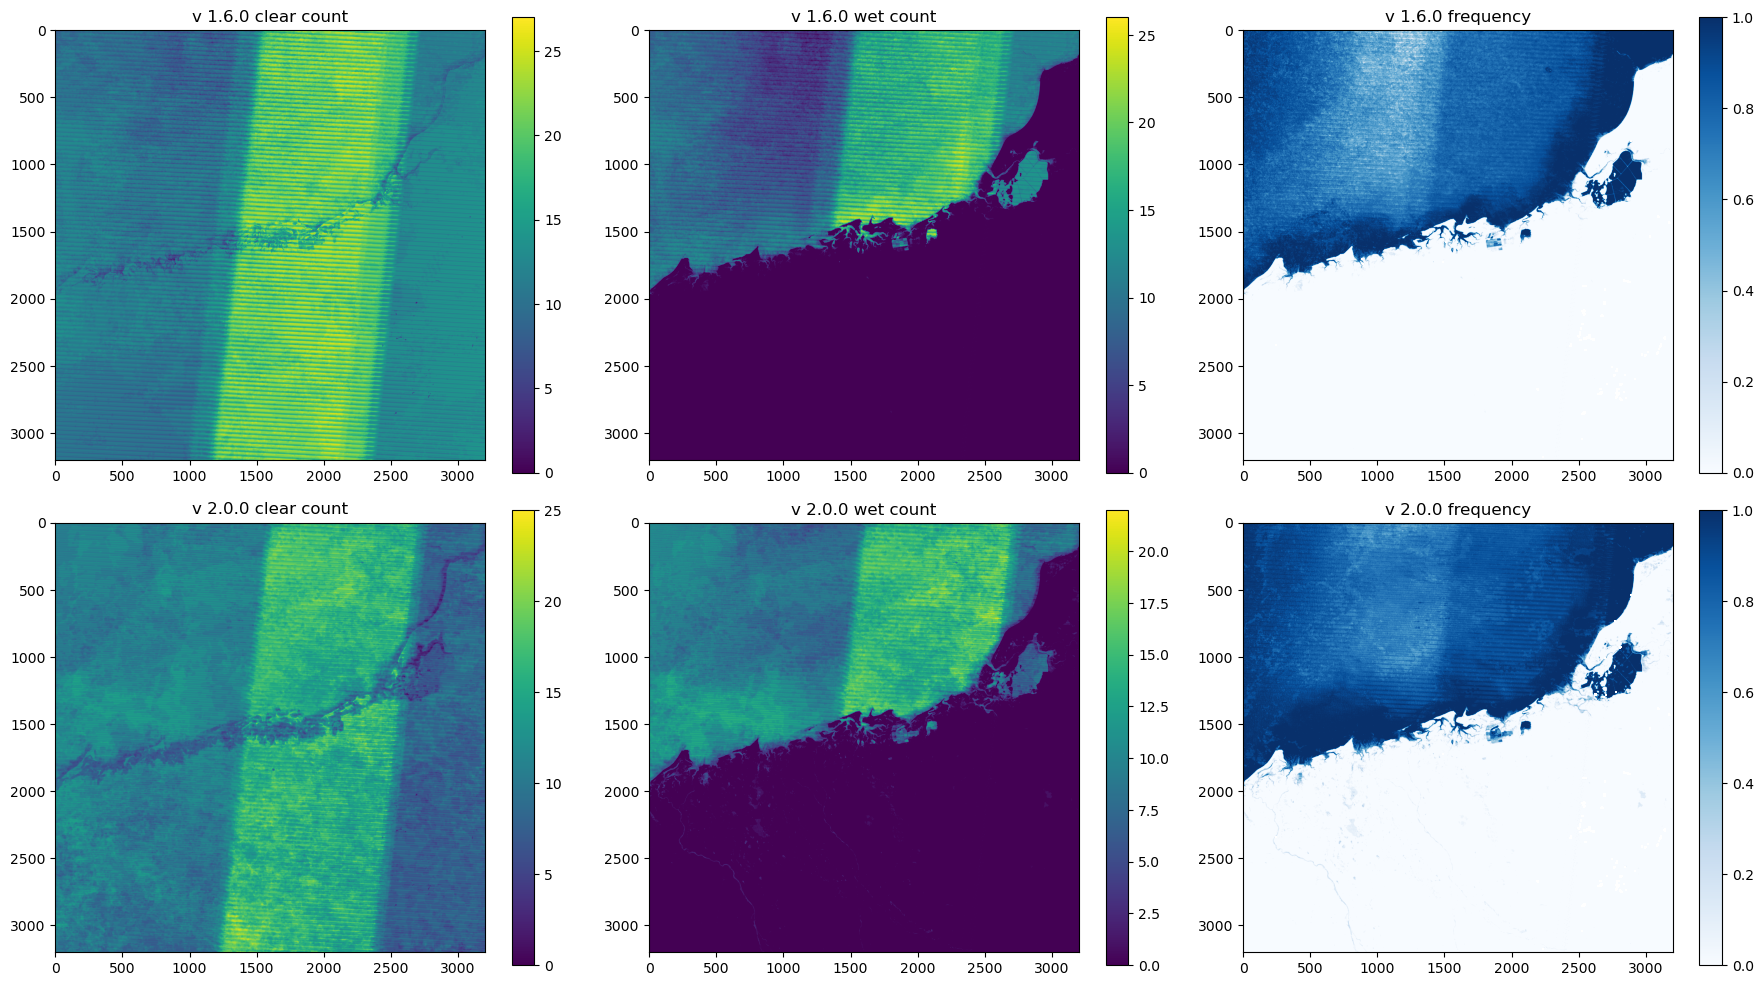

---------------------------------
-------------x42y53--------------
---------------------------------
V 1.6.0 NaN count (clear): 0
V 2.0.0 NaN count (clear): 0
NaN percent change: 0.00%
---------------------------------


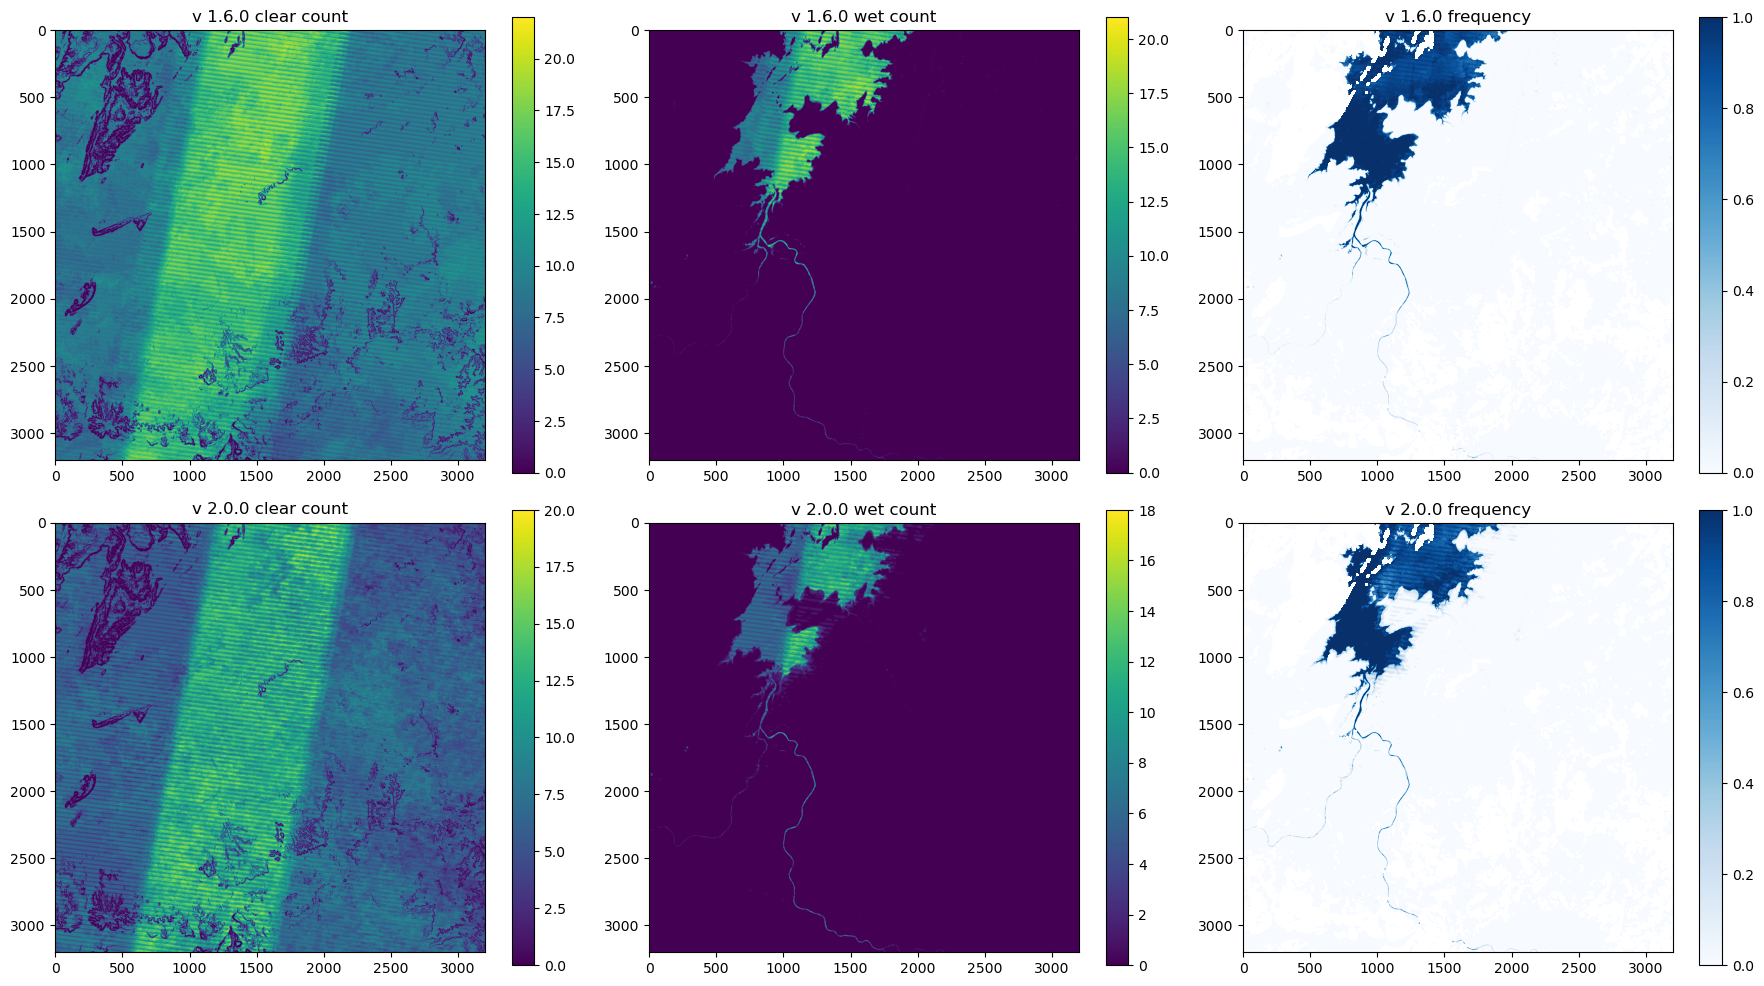

---------------------------------
-------------x54y52--------------
---------------------------------
V 1.6.0 NaN count (clear): 0
V 2.0.0 NaN count (clear): 0
NaN percent change: 0.00%
---------------------------------


In [ ]:
tiles = ['x36y35', 'x31y48', 'x42y53', 'x54y52', 'x62y47', 'x65y33', 'x60y30', 'x58y22', 'x55y33', 'x49y36', 'x51y39']

for tile in tiles: 
    plot_tile(tile, '2010')

In [ ]:
tiles = ['x36y35', 'x31y48', 'x42y53', 'x54y52', 'x62y47', 'x65y33', 'x60y30', 'x58y22', 'x55y33', 'x49y36', 'x51y39']

for tile in tiles: 
    plot_tile(tile, '2015')

In [ ]:
tiles = ['x36y35', 'x31y48', 'x42y53', 'x54y52', 'x62y47', 'x65y33', 'x60y30', 'x58y22', 'x55y33', 'x49y36', 'x51y39']

for tile in tiles: 
    plot_tile(tile, '1990')

In [ ]:
tiles = ['x36y35', 'x31y48', 'x42y53', 'x54y52', 'x62y47', 'x65y33', 'x60y30', 'x58y22', 'x55y33', 'x49y36', 'x51y39']

for tile in tiles: 
    plot_tile(tile, '2022')